<a id='TOC'/>

### TOC (table of content)
1. [Loading packages](#loading_packages)
2. [Loading data](#loading_data)
3. [Vectorizer](#vectorizer)
4. [Model](#model)
5. [Improvements](#improvements)
6. [Neural network](#neural_network)

<a id='loading_packages'/>

### Loading packages
[Back to TOC](#TOC)

In [344]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb


import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Deep learning: 
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import io
import re
import string

[nltk_data] Downloading package wordnet to /home/karol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/karol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<a id='loading_data'/>

### Loading data
[Back to TOC](#TOC)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df=df_train.copy()
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB


Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(
    "The data contains {} actual disasters ({:.2%} of all data).".format(
        df[df.target == 1].shape[0],
        df[df.target == 1].shape[0] / df.shape[0],
    )
)

The data contains 3271 actual disasters (42.97% of all data).


In [5]:
print(
    "Examples of actual disaster tweet: \n    {}\n    {}".format(
        df[df.target == 1].sample(1).text.iloc[0],
        df[df.target == 1].sample(1).text.iloc[0],
    )
)
print(
    "\nExamples of a tweet with no disaster behind it: \n    {}\n    {}".format(
        df[df.target == 0].sample(1).text.iloc[0],
        df[df.target == 0].sample(1).text.iloc[0],
    )
)

Examples of actual disaster tweet: 
    Police kill hatchet-wielding gunman who opened fire inside Nashville movie theater: AåÊmiddle-aged manåÊarmed wi... http://t.co/tyD47NfL5x
    Hmm...this could be problem for some researchers: FedEx no longer to transport select agents http://t.co/9vIibxgjAV via @usatoday

Examples of a tweet with no disaster behind it: 
    @ego_resolution im glad. My gay can heal 1000 wounds
    China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this su... http://t.co/KABK3tcJNL ...  via @Forbes


<a id='vectorizer'/>

### Vectorizer
[Back to TOC](#TOC)

In [279]:
X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["target"], random_state=777,test_size=0.2, stratify=df_train["target"])


In [281]:
print(
    "Length of train set: {}\n Length of test set: {}\n".format(len(X_train), len(X_val))
)



Length of train set: 6090
 Length of test set: 1523



Transform the text so that each word is a separate feature and count how many times that word occurs. (Save as a sparse matrix.)

In [282]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

# transform the text in the training data to a text-term matrix
X_train_vectorized = vect.transform(X_train)

vect

CountVectorizer()

Vocabulary sample:

In [283]:
sorted(vect.vocabulary_.items())[4000:4010]

[('condemnation', 4000),
 ('condemns', 4001),
 ('condenses', 4002),
 ('condition', 4003),
 ('conditions', 4004),
 ('conditionsprivation', 4005),
 ('condo', 4006),
 ('condolence', 4007),
 ('condolences', 4008),
 ('condos', 4009)]

In [284]:
full_vocab_len=len(vect.vocabulary_)

print(
    "The training data contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data contains 18543 different words (columns) across 6090 messages (rows).


Show the (sparse) feature matrix:

In [285]:
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<a id='model'/>

### Model
[Back to TOC](#TOC)

Let's train a logistic regression model with the train data

In [286]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(vect.transform(X_val))
predict_probab = model.predict_proba(vect.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.79842
AUC = 0.842


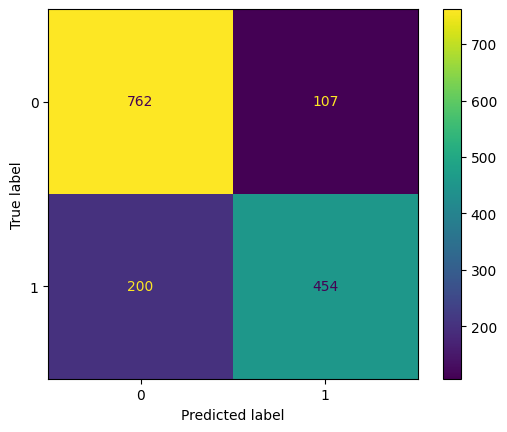

In [287]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

Let's check which words are most probably associated with actual disasters and which are not.

In [288]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = model.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['full' 'ebay' 'bags' 'song' 'nowplaying' 'obliteration' 'new' 'cake'
 'poll' 'sure' 'flattened' 'gets' 'lmao' 'job' 'long' 'upheaval'
 'australia' 'panic' 'join' 'quick']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'fires' 'storm' 'wildfire' 'earthquake' 'derailment' 'train'
 'typhoon' 'floods' 'california' 'bombing' 'terrorism' 'drought' 'tornado'
 'massacre' 'casualties' 'hurricane' 'flood' 'riots' 'volcano']


<a id='improvements'/>

### Improvements
[Back to TOC](#TOC)

Let's try to improve our prediction by considering term frequency using TF-IDF 

In [289]:
#Consider only words that occur in at least 3 tweets.
vect = TfidfVectorizer(min_df=3).fit(X_train)


X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items())[150:160]

[('active', 150),
 ('activity', 151),
 ('acts', 152),
 ('actual', 153),
 ('actually', 154),
 ('add', 155),
 ('added', 156),
 ('adding', 157),
 ('address', 158),
 ('admits', 159)]

In [290]:
print(
    "The training data now contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data now contains 3781 different words (columns) across 6090 messages (rows).


In [291]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding tfidf values
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:20]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-21:-1]]))

Smallest tfidf:
['vid' 'trubgme' 'ksawlyux02' 'sh' 'sm' 'time2015' 'utc2015' 'rwy' 'wnd'
 'inst' 'taxiways' '2030' 'navbl' 'tmp' 'apch' 'oper' 'starring' 'curved'
 '300w' '53inch']

Largest tfidf: 
['crushed' 'thunder' 'you' 'sinking' 'emergency' 'exploded' 'survive'
 'wreck' 'what' 'obliterated' 'flames' 'flattened' 'thanks' 'no' 'blight'
 'destroyed' 'murderer' 'mudslide' 'hurricane' 'trauma']


In [292]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(vect.transform(X_val))
predict_probab = model.predict_proba(vect.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.79777
AUC = 0.845


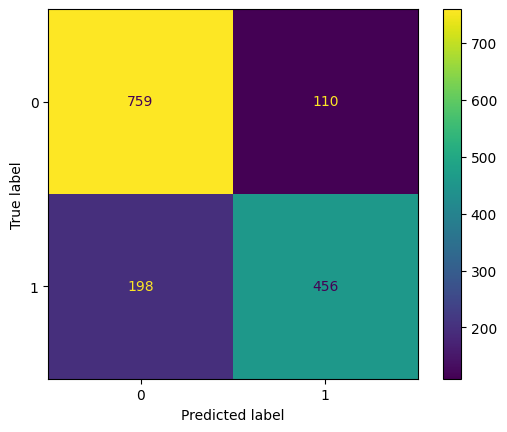

In [293]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

In [294]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = model.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['you' 'new' 'full' 'my' 'body' 'bags' 'nowplaying' 'ebay' 'me'
 'flattened' 'love' 'blight' 'panic' 'upheaval' 'obliteration' 'demolish'
 'or' 'song' 'crushed' 'day']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'in' 'fires' 'california' 'storm' 'train' 'wildfire' 'fire'
 'killed' 'bombing' 'earthquake' 'suicide' 'disaster' 'typhoon' 'drought'
 'murder' 'japan' 'derailment' 'forest' 'near']


Using TF-IDF, we have increased our accuracy score slightly.

Let's make the texts more comparable by using stemming.

In [295]:
stemmer = nltk.PorterStemmer()
cv_analyzer = TfidfVectorizer(min_df=2).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in cv_analyzer(doc))

stem_vectorizer = TfidfVectorizer(min_df=2, analyzer = stemmed_words)
X_train_stem_vectorized = stem_vectorizer.fit_transform(X_train)

In [296]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_stem_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(stem_vectorizer.transform(X_val))
predict_probab = model.predict_proba(stem_vectorizer.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.79842
AUC = 0.853


Stemming reduces the accuracy again. What about Lemmatization?

In [297]:
WNlemma = nltk.WordNetLemmatizer()
cv_analyzer = TfidfVectorizer(min_df=4).build_analyzer()


def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in cv_analyzer(doc))

lemm_vectorizer = TfidfVectorizer(min_df=4, analyzer = lemmatize_word)


X_train_lemm_vectorized = lemm_vectorizer.fit_transform(X_train)

In [298]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_lemm_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(lemm_vectorizer.transform(X_val))
predict_probab = model.predict_proba(lemm_vectorizer.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.78989
AUC = 0.847


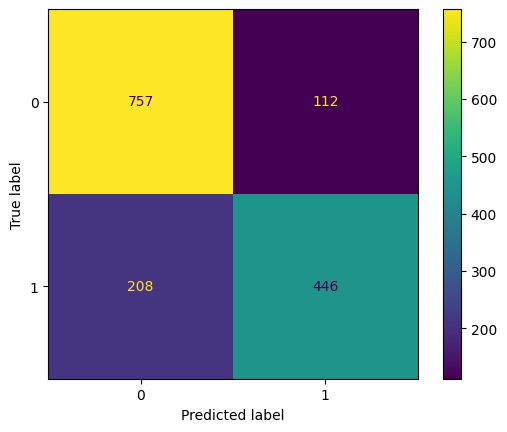

In [299]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

### Nope. Lemmatization slightly reduces the accuracy score compared to the unchanged TF-IDF vectorized data.

### Next, let's test a neural network.

<a id='neural_network'/>

### Neural network
[Back to TOC](#TOC)

In [412]:
# Splitting original training data in train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.2, stratify=df.target)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('train size:', len(y_train))

print('test size:', len(y_test))

print('val size:', len(y_val))


# convert datasets for use in Keras


dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

dataframe_train=pd.concat([X_train,y_train], axis=1)
dataframe_test=pd.concat([X_test,y_test], axis=1)

# create batches of the datasets for training, validation and testing

batch_size=500
dataset_train_batch = dataset_train.batch(batch_size=batch_size)
dataset_val_batch = dataset_val.batch(batch_size=batch_size)
dataset_test_batch = dataset_test.batch(batch_size=batch_size)

train size: 4872
test size: 1523
val size: 1218


Define Vecorizer

In [410]:
def custom_standardization(input_data):
    """Text preprocessing: lowercases, no punctuation

    Args:
        input_data (tf.dataframe): [text, formated as tf.string]

    Returns:
        [tf.dataframe]: [preprocessed text]
    """
    text_lower = tf.strings.lower(input_data)
    return tf.strings.regex_replace(text_lower, '[%s]' % re.escape(string.punctuation), '')

# get the number of words in each message
sequence_len = int(dataframe_train.text.apply(lambda x: len(x.split())).max()) 

# define the text vectorization layer 
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=full_vocab_len,
    output_mode='int',
    output_sequence_length=sequence_len)

# Make a text-only dataset (without labels)
train_text = dataset_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [411]:
print("1138 ---> ",vectorize_layer.get_vocabulary()[1138])
print(" 327 ---> ",vectorize_layer.get_vocabulary()[327])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1138 --->  phoenix
 327 --->  charged
Vocabulary size: 16562


### Define the model. Note that it uses word embeddings.

In [420]:
tf.keras.backend.clear_session()

embedding_dim=3
model = Sequential([
  vectorize_layer,
  Embedding(full_vocab_len, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dropout(0.5),
  Dense(500, activation='relu'),
  Dropout(0.25),
#  Dense(16, activation='elu'),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])


In [421]:
# training the model

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)



model.fit(
    dataset_train_batch,
    validation_data=dataset_val_batch,
    epochs=100,
    callbacks=[early_stopping_monitor]
    )


Epoch 1/100
10/10 [==============================] - 2s 45ms/step - loss: 0.6893 - auc: 0.5056 - val_loss: 0.6852 - val_auc: 0.5511
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6835 - auc: 0.5143 - val_loss: 0.6824 - val_auc: 0.5602
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6821 - auc: 0.5526 - val_loss: 0.6818 - val_auc: 0.6146
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 0.6802 - auc: 0.6145 - val_loss: 0.6803 - val_auc: 0.6726
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6781 - auc: 0.6459 - val_loss: 0.6782 - val_auc: 0.7188
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.6750 - auc: 0.6816 - val_loss: 0.6750 - val_auc: 0.7510
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.6696 - auc: 0.7162 - val_loss: 0.6702 - val_auc: 0.7852
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 0.

In [424]:
# calculating the loss and accuracy on the test set.
loss, accuracy = model.evaluate(dataset_val_batch, verbose=2)

3/3 - 0s - loss: 0.4533 - auc: 0.8605 - 32ms/epoch - 11ms/step


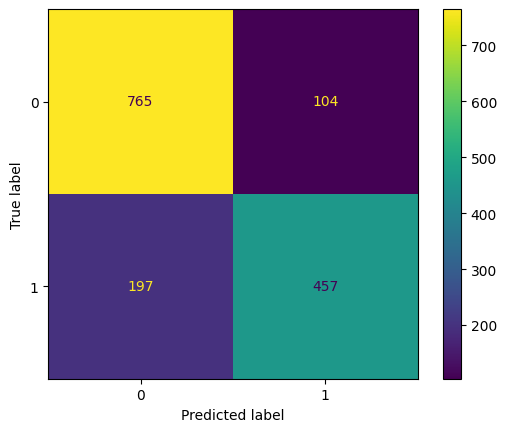

In [426]:
y_test_pred_classes = (
    pd.DataFrame(model.predict(tf.data.Dataset.from_tensor_slices((X_test)).batch(batch_size=batch_size), verbose=0)
    .flatten())
    .applymap(lambda x: 1 if x>0.5 else 0)
    .rename(columns={0:'pred'})
)
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(np.array(dataframe_test.target), np.array(y_test_pred_classes.pred)))
confusion_matrix_model.plot()

### This model is slightly better than the TF-IDF-vectorized Logistic Regression model from before (6 more true negatives and 1 more true positive).